In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from scipy import stats
from sklearn.feature_selection import chi2,SelectKBest
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score,plot_roc_curve
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from pickle import dump
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
data = pd.read_csv("Data.csv")
X = data.iloc[:,0:-1]
y = data.iloc[:,-1]

## Remove NaN

In [4]:
def NA(col):
    count = X[col].isna().sum()
    return count

In [5]:
dropCol = []
for col in X.columns:
    if NA(col)/len(X) > 0.5:
        dropCol.append(col)
X = X.drop(columns = dropCol)
print(X.shape)

(39508, 342)


In [6]:
categoricalColumn = []
nonCategoricalColumn = []
for col in X:
    if X[col].dtype == "object":
        categoricalColumn.append(col)
    else:
        nonCategoricalColumn.append(col)

In [7]:
for col in nonCategoricalColumn:
    X[col].fillna((data[col].mean()), inplace = True)

In [8]:
for col in categoricalColumn:
    X[col].fillna("U", inplace = True)

In [9]:
X.isna().sum().sum()

0

## Categorical Variable Selection

def chisquare(column):
    ct = pd.crosstab(X[column],y)
    p = stats.chi2_contingency(ct)[1]
    return p

SignificantCategorical = []
for col in categoricalColumn:
    if len(Counter(X[col])) < 15:
        if chisquare(col) < 0.05:
            SignificantCategorical.append(col)

len(SignificantCategorical)

## Select BestK chisquare

In [10]:
def chi(X, y):
    X = X.astype(str).apply(LabelEncoder().fit_transform)
    bestfeatures = SelectKBest(score_func=chi2, k=10)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    #print(featureScores.nlargest(26,'Score'))
    return featureScores.sort_values(by = ["Score"], ascending = False)

In [11]:
SignificantCategorical = chi(X[categoricalColumn],y).iloc[2:10,0].tolist()

## Numerical Variable Selection

In [12]:
def numerical(X,y):
    fs = SelectKBest(score_func=f_classif, k = 50)
    fs.fit(X,y)
    sup = fs.get_support()
    fn = X.loc[:, sup].columns.tolist()
    return fn

In [13]:
significantNon = numerical(X[nonCategoricalColumn],y)

In [14]:
total = SignificantCategorical + significantNon

In [15]:
dump(significantNon, open('significantNon.pkl','wb'))

## OneHotEncode

In [16]:
X = pd.get_dummies(X[total], drop_first = True)

In [17]:
X.head()

,LifestyleMedicalPolicy,ActIntAttendsEducationProg,BuyerLuxuryHomeGoodShopper,ActIntEBookReader,ActIntPlaysTennis,StyleHighFreqCruiseEnthus,StyleHighFreqDomesticVac,StyleHighFreqForeignVac,StyleFrequentFlyerPrgMbr,StyleHotelGuestLoyaltyPrg,...,HomeBusinessIndicator_7,HomeBusinessIndicator_8,HomeBusinessIndicator_9,HomeBusinessIndicator_U,HomeBusinessIndicator_Y,I4PersonType_1,I4PersonType_E,I4PersonType_O,I4PersonType_U,I4PersonType_Y
0,69.000000,67.000000,56.000000,78.000000,48.000000,48.000000,41.000000,26.000000,52.000000,60.000000,...,0,0,0,1,0,0,0,0,1,0
1,14.000000,10.000000,5.000000,11.000000,11.000000,18.000000,6.000000,2.000000,2.000000,9.000000,...,0,0,0,1,0,0,0,0,1,0
2,65.613084,38.547193,51.699769,42.926365,39.833262,54.125535,50.818501,51.311997,50.748417,53.332663,...,0,0,0,0,0,0,0,0,0,0
3,65.613084,38.547193,51.699769,42.926365,39.833262,54.125535,50.818501,51.311997,50.748417,53.332663,...,0,0,0,0,0,0,0,0,0,0
4,65.613084,38.547193,51.699769,42.926365,39.833262,54.125535,50.818501,51.311997,50.748417,53.332663,...,0,0,0,0,0,0,0,0,0,0


In [18]:
dump(total, open('total.pkl','wb'))

## Spilit Dataset

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y.values)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify = y_train.values)

## Handling Imbalanced Data

OverSampling = RandomOverSampler(0.9)
X_train_res, y_train_res = OverSampling.fit_sample(X_train,y_train)
print(X_train_res.shape, y_train_res.shape)
print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

In [20]:
UndeSampling = RandomUnderSampler(0.8)
X_train_res, y_train_res = UndeSampling.fit_sample(X_train, y_train)
print(X_train_res.shape, y_train_res.shape)
print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

(5535, 136) (5535,)
Original dataset shape Counter({0: 21244, 1: 2460})
Resampled dataset shape Counter({0: 3075, 1: 2460})


## Normalize Data

In [21]:
scale = preprocessing.StandardScaler().fit(X_train_res[significantNon])
X_train_res[significantNon] = scale.transform(X_train_res[significantNon])
X_train_norm_model = X_train_res
X_test[significantNon] = scale.transform(X_test[significantNon])
X_test_norm = X_test
X_val[significantNon] = scale.transform(X_val[significantNon])
X_val_norm = X_val

In [22]:
dump(scale, open('scaler.pkl','wb'))

## Create Model

In [23]:
def create_model():
    # Create Model
    model = Sequential()
    model.add(Dense(100, activation = "relu", input_dim = len(X_train_res.columns)))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = "sigmoid"))
    # Complie model
    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return model

In [24]:
model = create_model()

## Model Fit

In [25]:
from sklearn.utils import class_weight

In [26]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_res), y_train_res)

In [27]:
class_weights

array([0.9  , 1.125])

In [28]:
model.fit(X_train_norm_model, y_train_res, batch_size = 25, epochs = 50, validation_data = (X_val_norm, y_val), class_weight = class_weights, verbose = 1)

Train on 5535 samples, validate on 7902 samples
Epoch 1/50
5535/5535 [==============================] - 1s 167us/step - loss: 0.6694 - accuracy: 0.5998 - val_loss: 0.6088 - val_accuracy: 0.6891
Epoch 2/50
5535/5535 [==============================] - 1s 123us/step - loss: 0.6475 - accuracy: 0.6179 - val_loss: 0.5635 - val_accuracy: 0.7231
Epoch 3/50
5535/5535 [==============================] - 1s 112us/step - loss: 0.6338 - accuracy: 0.6394 - val_loss: 0.5826 - val_accuracy: 0.6654
Epoch 4/50
5535/5535 [==============================] - 1s 112us/step - loss: 0.6202 - accuracy: 0.6594 - val_loss: 0.5576 - val_accuracy: 0.6962
Epoch 5/50
5535/5535 [==============================] - 1s 110us/step - loss: 0.6109 - accuracy: 0.6578 - val_loss: 0.5525 - val_accuracy: 0.7069
Epoch 6/50
5535/5535 [==============================] - 1s 118us/step - loss: 0.6049 - accuracy: 0.6603 - val_loss: 0.5874 - val_accuracy: 0.6596
Epoch 7/50
5535/5535 [==============================] - 1s 118us/step - loss

## Model Evaluation

In [29]:
model.evaluate(X_test_norm, y_test)

7902/7902 [==============================] - 0s 20us/step


[0.7961789876471529, 0.6349025368690491]

## Confusion Matrix

In [30]:
prediction = model.predict(X_test_norm)
classfication = model.predict_classes(X_test_norm)
pc = []
for i in range(len(classfication)):
    pc.append(classfication[i][0])
realy = []
for i in y_test:
    realy.append(i)

In [31]:
def cm(target,prediction):
    result = pd.DataFrame({"Target": target, "Prediction": prediction})
    table = pd.crosstab(result["Prediction"],result["Target"])
    print("sensitivity:",table.iloc[0,0]/table.iloc[:,0].sum())
    print("specificity:",table.iloc[1,1]/table.iloc[:,1].sum())
    print("accuracy:", (table.iloc[1,1] + table.iloc[0,0])/table.sum().sum())
    return table

In [32]:
cm(realy,pc)

sensitivity: 0.6392262072860774
specificity: 0.5975609756097561
accuracy: 0.634902556314857


Target,0,1
Prediction,,
0,4527,330
1,2555,490


## ROC Curve

In [33]:
probability = []
for i in prediction.tolist():
    probability.append(i[0])

In [34]:
def roc(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold']) 

In [35]:
bestthreshold = roc(y_test.tolist(), probability)
bestthreshold

[0.4737793207168579]

In [36]:
def plot_roc(target, predicted):
    fp, tp, _ = roc_curve(target, predicted)
    plt.plot(fp, tp, label='ROC', linewidth=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(
      [0, 1], [0, 1], 
      linestyle='--',  
      color='r',
      label='Chance'
    )

    plt.legend(loc="lower right")

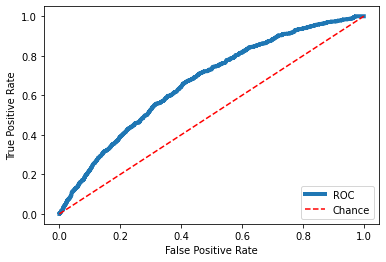

In [37]:
plot_roc(y_test.tolist(), probability)

In [38]:
def threshold_prediction(prediction, threshold):
    Newprediction = np.where(prediction > threshold, 1, 0)
    returnlist = []
    for i in Newprediction:
        returnlist.append(i[0])
    return returnlist

In [39]:
cm(realy,threshold_prediction(prediction, bestthreshold))

sensitivity: 0.6177633436882237
specificity: 0.6170731707317073
accuracy: 0.6176917236142748


Target,0,1
Prediction,,
0,4375,314
1,2707,506


## Save Model

In [40]:
model.save("HW2_Model.h5")

In [41]:
SaveModel = load_model("HW2_Model.h5")

In [42]:
SaveModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               13700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 23,901
Trainable params: 23,901
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               13700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 23,901
Trainable params: 23,901
Non-trainable params: 0
_________________________________________________________________


## Summary

(a) Overall discovery process <br>
(b) List of variables used in the model <br>
(c) Detailed analysis on model performance (e.g. ROC curves, confusion matrix, etc.) <br>
(d) Limiting factors/issues encountered and assumptions made <br>


### Overall process

From the beginning of this discovery process, the first step is to remove NAs. For numerical variables, NAs were replaced by the mean of the column. For categorical variables, NAs were replaced by "U" which means unknown referring to the data dictionary. When counting NAs for each column, some columns have more than 50% NAs. These columns were removed. Next step is feature selection. Our target variable is categorical variable. When handling numerical input and categorical output, ANNOVA f-test was applied to find out the best 25. When handling categorical input and categorical output, chi-square was applied to find out the best 8 variables. <br>

Then I used get dummy for categorical variable. And original data was splitted into train, validation and test set. Because this dataset is imbalanced, I tried oversampling and undersampling method. Finally I decided to use undersampling which will perform a better performance on accuracy for class 1. <br>

Before creating model, I did normalize the train, validation and test dataset. By the way, validation and test set were normalized based on the scaling parameters of train. <br>

I created deep learner model with 3 layers. The output is binary so I used sigmoid. 

### variables used in the model

In [44]:
print(total)

['MosaicGlobalZip4', 'I4GenderCode', 'I2GenderCode', 'I2PersonType', 'I1PresenceofSSN', 'PhoneMatchType', 'HomeBusinessIndicator', 'I4PersonType', 'LifestyleMedicalPolicy', 'ActIntAttendsEducationProg', 'BuyerLuxuryHomeGoodShopper', 'ActIntEBookReader', 'ActIntPlaysTennis', 'StyleHighFreqCruiseEnthus', 'StyleHighFreqDomesticVac', 'StyleHighFreqForeignVac', 'StyleFrequentFlyerPrgMbr', 'StyleHotelGuestLoyaltyPrg', 'FinMajorCreditCardUser', 'AVGTRD', 'AVGTRDNVRDELDRG', 'AVGBCCTRD', 'AVGINQ', 'AVGREVTRD', 'CreditSeekers', 'AgePop3544', 'AgePop6599', 'AgePop7599', 'BuiltHUMedHUAge', 'EducPop25HSDiploma', 'EducPop25BachDegree', 'EmployPopFem16InLbFrc', 'EthnicPopAsian', 'IncHHHHInc010K', 'IncHHHHInc1014K', 'IncHHHHInc1519K', 'IncHHHHInc2024K', 'IncHHHHInc100124K', 'IncHHHHInc125149K', 'IncHHHHInc150199K', 'IncHHMedHHInc', 'IndusEmpldFinanceInsur', 'MortgOOHUOneMrtgOnly', 'MoveOCCHUMedLenofRes', 'EducISPSA', 'EducISPSADecile', 'IncFamilyIncStateIndex', 'IncFamilyIncStateDecile', 'HighvsLowAff

### ROC curves, confusion matrix

Based on the model results, our accuracy is about 63%, specificity is about 56% and sensitivity is about 65%. This is not a good model based. But I have made a lot of attempts to get a better accuracy. For some attempts, accuracy was increased but the specificity was decreased which means the model is not predicting class 1 very well. If we want to get a higher accuracy on predicting class 1, the overall accuracy will be decreased.

### Assumptions/Limitation

Because the data is imbalanced, we can only make up a balanced data. But the data in the real world is not balaced, I may think this is an limitation for training our model. <br>
Too many NAs would cause some columns or rows useless.

Assumption for chi-square:<br>
Each observation is independent of all the others <br>
No more than 20% of the expected counts are less than 5 and individual expected counts are 1 or greater <br>

Assumption for ANOVA F-test: <br>
Each population from which a sample is taken is assumed to be normal. Each sample is randomly selected and independent. The populations are assumed to have equal standard deviations (or variances).